In [7]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
import os
import seaborn as sns
import pandas as pd
markers = itertools.cycle(['o','s','v', '+'])

import matplotlib.colors as mcolors
# get all the colors
colors = itertools.cycle(list(mcolors.TABLEAU_COLORS)[:30])
#%matplotlib

disorder_pbc = "../results/disorder/PBC/"
symm_pbc = "symmetries/PBC/"

# String separators and helper functions

In [8]:
# Function to convert  
def listToString(s, separator = ","): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += str(ele)+separator  
    
    # return string  
    return str1[:-1] 

In [9]:
def findDifferentElementsStrings(listOfStrings):
    different = []
    same = set()
    if len(listOfStrings) != 0:
        # create the intersection to distinguish same elements
        same = set(listOfStrings[0].split(","))
        for i in range(1,len(listOfStrings)):
            tmp = set(listOfStrings[i].split(","))
            same = same.intersection(tmp)
        # after having the intersection find the list of names to put into legend that are different
        for i in range(0, len(listOfStrings)):
            tmp = set(listOfStrings[i].split(",")) - same
            different.append(listToString(tmp))
    # return same and list of different strings in the form of tuple
    return (listToString(same), different)

findDifferentElementsStrings(["g=1,h=2", "g=1,h=3,w=4"])

('g=1', ['h=2', 'w=4,h=3'])

# Handle all the files starting from a given name given by the user and distinguished by the parameters and return the list of dataframes

In [155]:
def check_header(filename):
    with open(filename) as f:
        first = f.read(1)
        return first not in '.-0123456789'

def handle_all_files(directory, file_begin, columns, distinguishers, separator = "\t\t"):
    dfs = []
    for filename in os.listdir(directory):
        if filename[-4:] != ".dat" or not filename.startswith(file_begin):
            continue
        # split the name and the parameters
        splitter = filename[:-4].split("_")
        # split each of the parameters 
        params = splitter[-1].split(",")
        skip = False

        for element in distinguishers:
            in_bucket = False
            for bucket in element:
                if bucket in params:
                    in_bucket = True
            if not in_bucket:
                skip = True
                break
        #if len(set(params).intersection(set(distinguishers))) == 0:
            #print(params, distinguishers)
            #skip = True
        if not skip or len(distinguishers) == 0:
            skip_rows = 0
            if check_header(directory + filename):
                skip_rows = 1
            tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0, names = columns)
            #print(tmp)
            tmp = tmp.loc[:,tmp.notna().all(axis=0)]
            dfs.append((tmp, listToString(params)))
    #print(dfs)
    return dfs

tmp = handle_all_files(symm_pbc, "IprScaling",["L", "ipr","information entropy", "$r_{goe}$"], [["g=0.81"]])[0][0]
tmp

<ipython-input-155-86784bc6b4e4>:32: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(directory + filename, sep = separator, header=None,skiprows = skip_rows, index_col = 0, names = columns)


,ipr,information entropy,$r_{goe}$
L,,,
12,0.196227,0.908261,0.485528
13,0.183345,0.915408,0.524820
14,0.168017,0.919669,0.491837
15,0.173051,0.926483,0.509969
16,0.182447,0.942251,0.521567
17,0.189973,0.951304,0.528571
18,0.195662,0.956700,0.522988
19,0.203073,0.961768,0.528217


In [156]:
def plotKurtosisFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        kurto = []
        if not pd.empty:
            labels.append("L=" + str(L))
                     
            kurtos = pd.kurtosis(axis = 0)
            #print(kurtos)
            kurto = [a for a in kurtos]
            values = [float(x.split("=")[-1]) for x in kurtos.index]                 # list of possible x_disting values
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            order = np.argsort(values)
            
            
            ax.plot(np.array(values)[order], np.array(kurto)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
                )
    #print(labels)       
    ax.set(title = "kurtosis of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "kurtosis(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([0,4.5])
    #ax.set_ylim([0,4])
    plt.savefig(directory + "kurtosis_" + name_of_file_start + ".png")
    plt.show()

plotKurtosisFromDF(directory + "./", "ProbDistSigmaX", "w", [12])

NameError: name 'directory' is not defined

In [157]:
def plotBinderFromDF(directory,name_of_file_start, x_distinguisher, Ls):
    
    fig, ax = plt.subplots(figsize=(15,15))
    labels = []
    for L in Ls:
        pd = filesToDataFrame(directory, name_of_file_start, L, x_distinguisher)
        values = []
        binder = []
        if not pd.empty:
            labels.append("L=" + str(L))
            
            square_pd = pd.apply(np.square, axis =1)
            fourth_pd=square_pd.apply(np.square, axis = 1)
            
            #print(square_pd)
            
            fourth_mean = [fourth_pd[a].mean() for a in fourth_pd.columns]
            square_mean = [square_pd[a].mean() for a in square_pd.columns]

            
            for i in range(len(square_mean)):
                binder.append(1 - fourth_mean[i]/(3*square_mean[i]))
            ##print(binder)
            values = [float(x.split("=")[-1]) for x in pd.columns]                 # list of possible x_disting values
            
            order = np.argsort(values)
            #print(kurto)
            #print(values)
            # print(len(kurto))
            # print(len(values))
            ax.plot(np.array(values)[order], np.array(binder)[order],
                    linewidth = 1.5,
                    marker = next(markers),
                    markersize = 4
            )
    #print(labels)       
    ax.set(title = "Binder cumulant of $\sigma _x$ probability distribution"
    , xlabel = x_distinguisher
    , ylabel = "U(P($\sigma _x$))")
    ax.legend(labels
      , frameon=False
      , loc='best'
      , fontsize=8)
    ax.set_xlim([-0,4.5])
    #ax.set_ylim([-80,10])
    plt.savefig(directory + "BinderCumulant_" + name_of_file_start + ".png")
    plt.show()

plotBinderFromDF(directory + "./", "ProbDistSigmaX", "w", [12])

NameError: name 'directory' is not defined

# Operators plotter as a function of energies, plots all elements connecting files with parameters present in the distinguisher

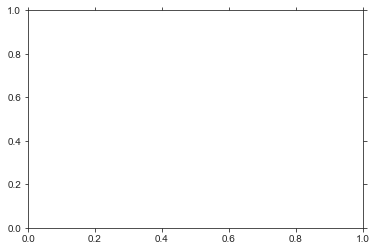

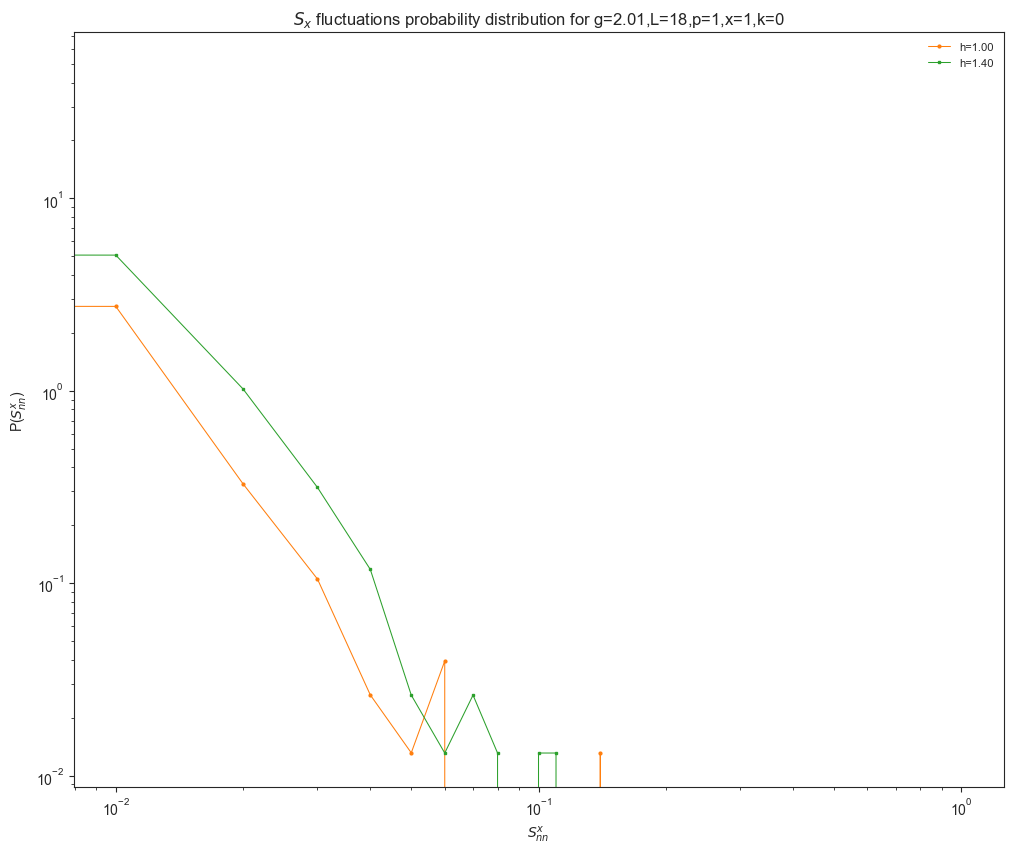

In [160]:
def plot_av_operator(directory, file_begin, columns, distinguishers, operator_name, scale_x = "linear", scale_y = "linear", separator = "\t\t"):
    try:
        plt.clf()
        plt.cla()
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, separator = separator)
        fig, ax = plt.subplots(len(columns) - 1, figsize=(12,10), dpi = 100)
        
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
        axis = []
        if len(columns) > 2: # if we have many columns to plot
            axis = [ax[i] for i in range(len(columns) - 1)]
        else:
            axis = [ax]
        
        savefile = file_begin + "_" + same_and_diff[0]
        # plot 
        for df in listOfDf:
            itr = 0
            for col in df[0].columns:
                df[0][col].plot(ax = axis[itr]
                        , linewidth=0.75
                        , marker=next(markers)
                        , markersize=2
                        , color = next(colors))
                itr+=1
        
        for i in range(0, len(columns) - 1):
            axis[i].set(title = columns[i+1] + " for " + same_and_diff[0] 
                    ,ylabel = operator_name)
            axis[i].legend(same_and_diff[1] 
                    , frameon=False
                    , loc='best'
                    , fontsize=8)
            axis[i].set_yscale(scale_y)
            axis[i].set_xscale(scale_x)
            #ax[i].set_xlim([-1.0,1.5])
            #ax[i].set_ylim([-0.4,0.4])
        plt.savefig(folder + savefile + ".pdf")
        plt.savefig(folder + savefile + ".png")
        plt.show()

# sigma_x                    
#plot_av_operator(symm_pbc, "SigmaX",columns = ["E/L", "<n|$S_x$|n>"], distinguishers = [], operator_name = "<n|$S_x$|n>") 
# sigma_x prob dist
plot_av_operator(symm_pbc, "ProbDistSigmaX",columns = ["$S^x_{nn}$", "$S_x$ fluctuations probability distribution"], distinguishers = [["L=18"],["g=2.01"]], operator_name = "P($S^x_{nn}$)", scale_y = 'log', scale_x = 'log', separator = '\t') 
# energy difference
#plot_av_operator(symm_pbc, "perturbationEnergyDiffDist",columns = ["E-E'", "P(E-E')"], distinguishers = [["L=18"],["g=0.81"], ["h=1.00"]], operator_name = "P(E-E')", scale_y = 'log', scale_x = 'log') 
# operators dist
#plot_av_operator(symm_pbc, "perturbationOperatorsDist",columns = ["$O_p$ - $O_{p+dp}$", "P1"], distinguishers = [["L=18"],["g=0.81"], ["h=2.60"]], operator_name = "P", scale_y = 'log', scale_x = 'log')    

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


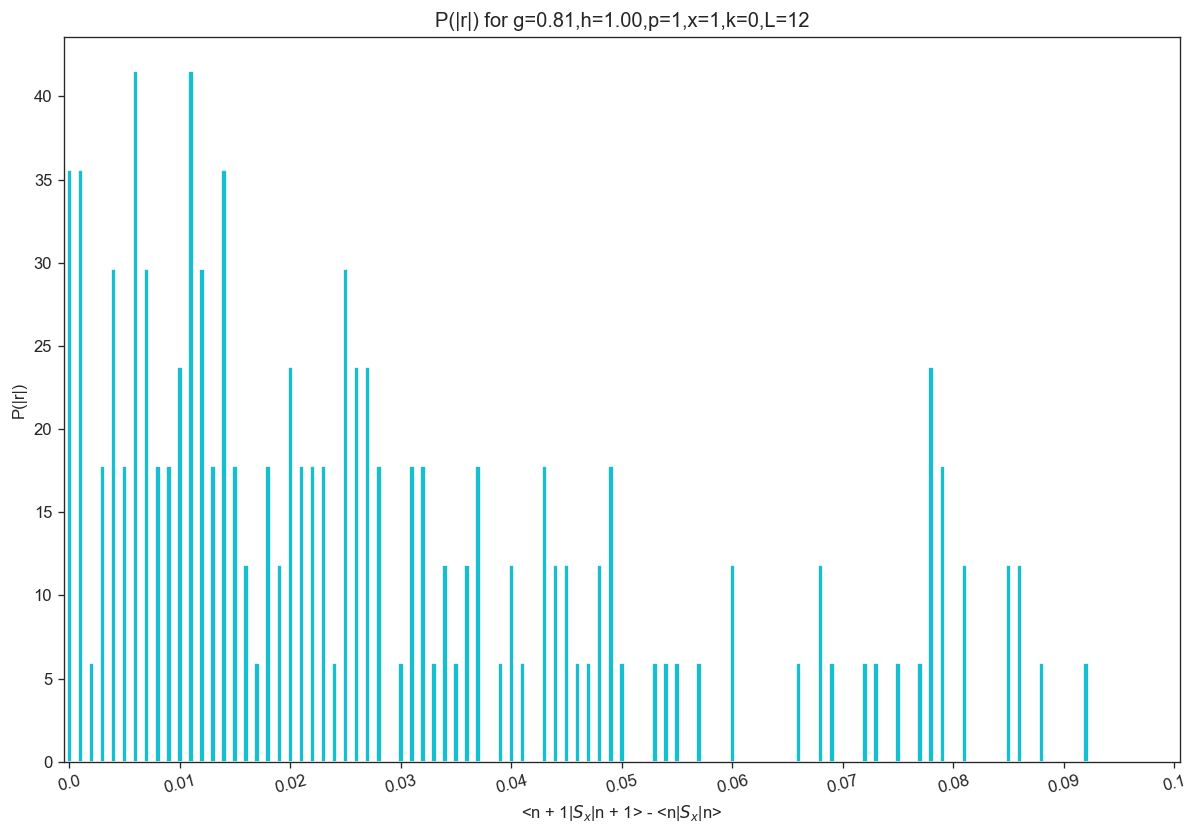

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


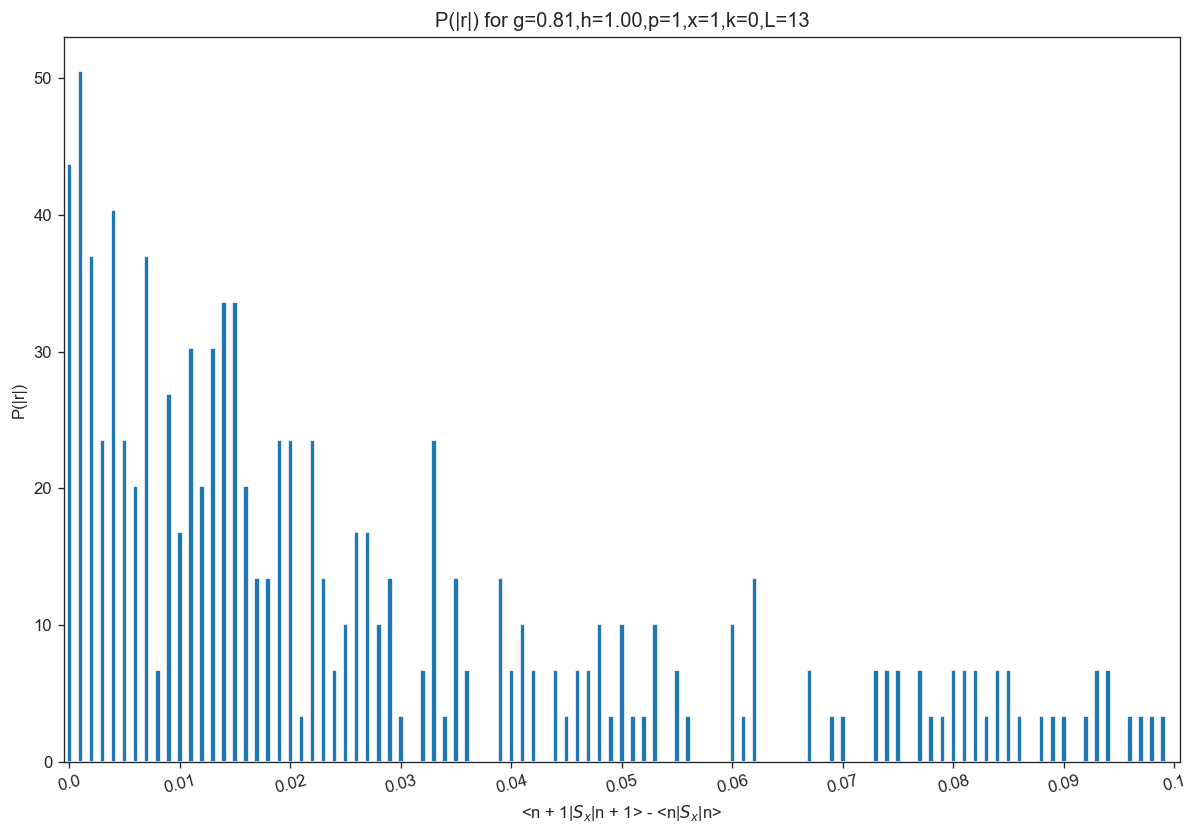

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


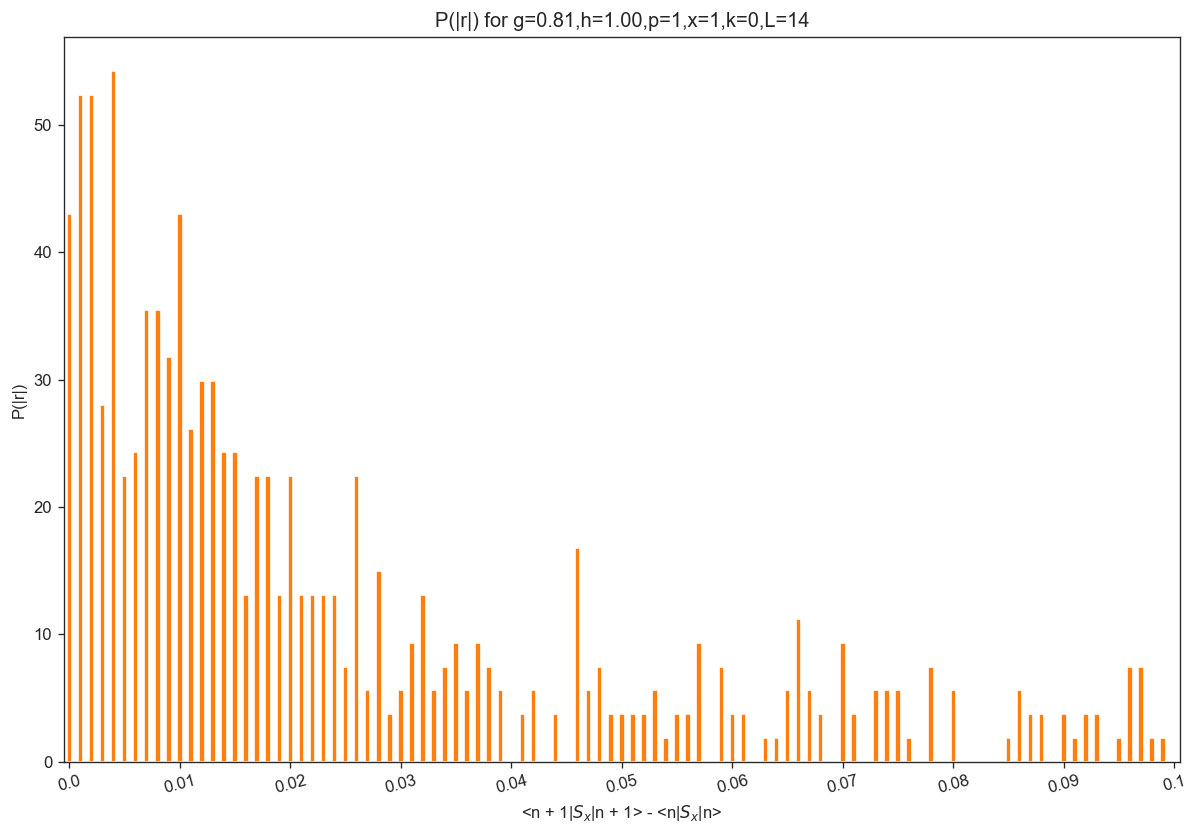

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


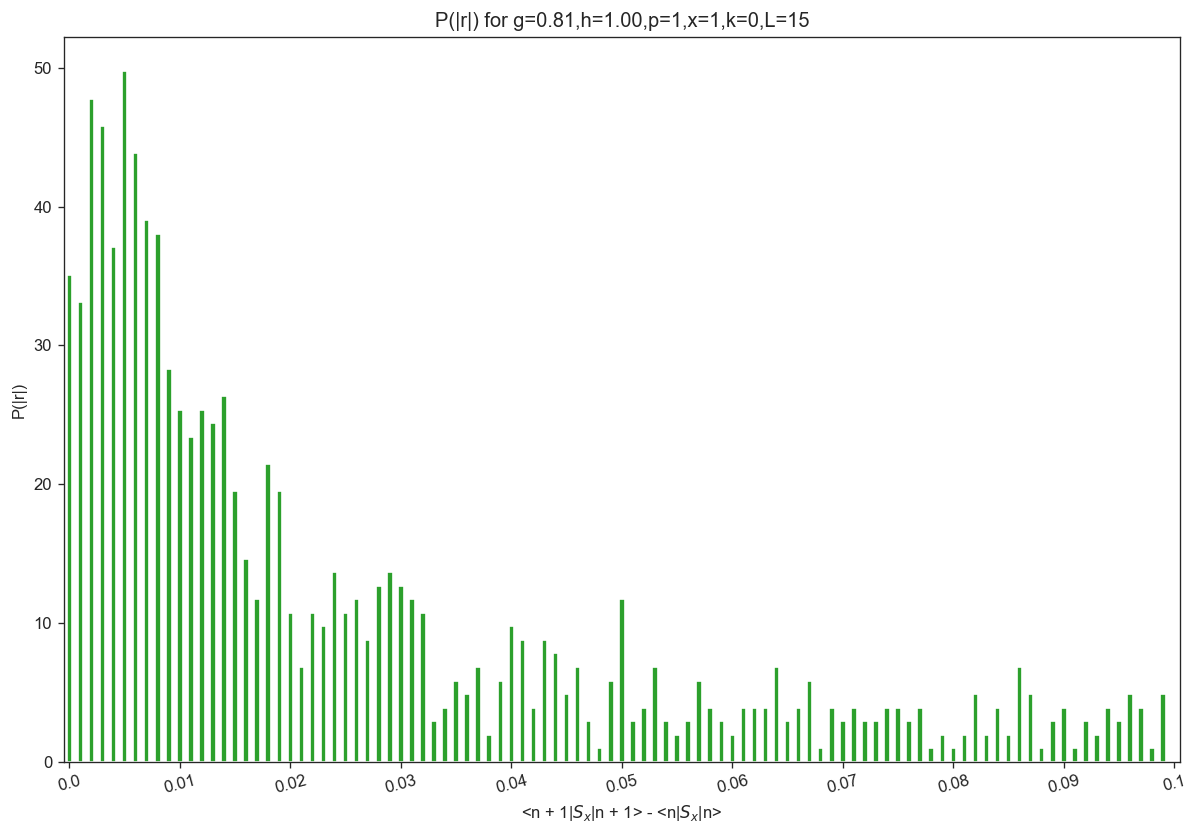

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


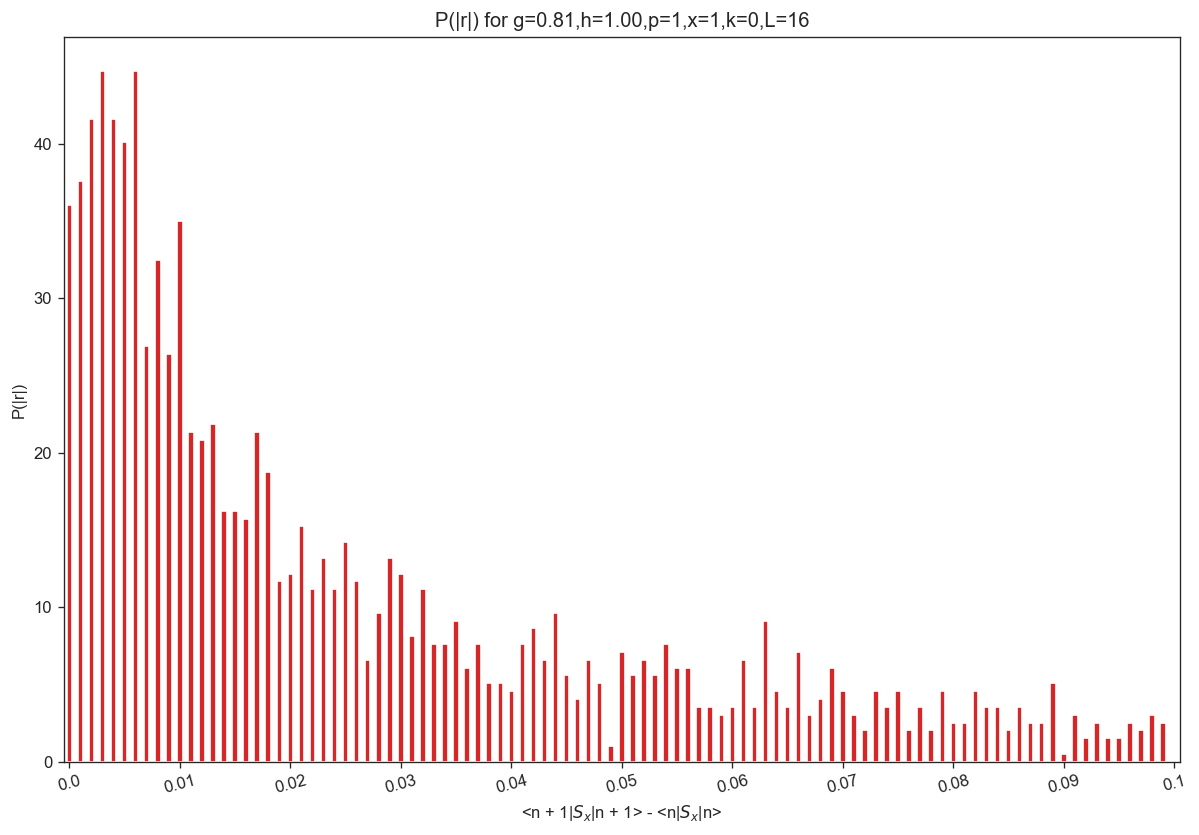

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


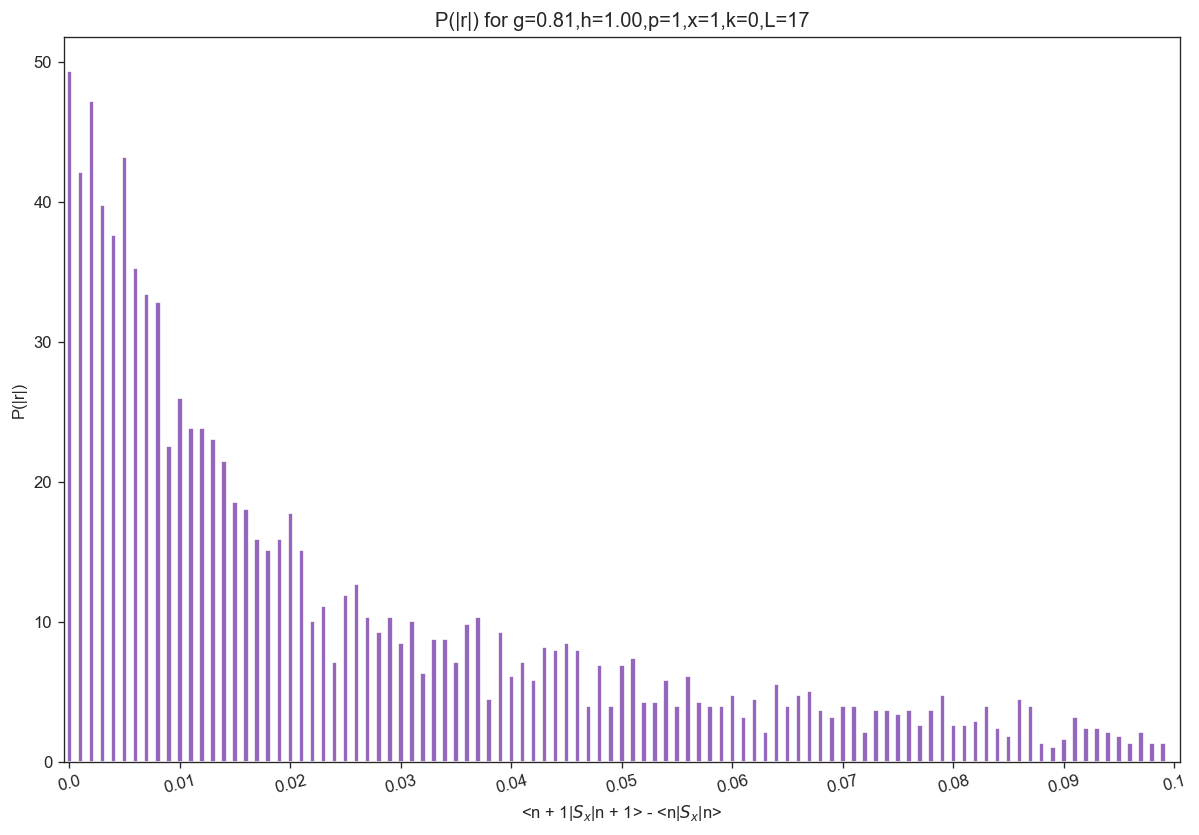

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


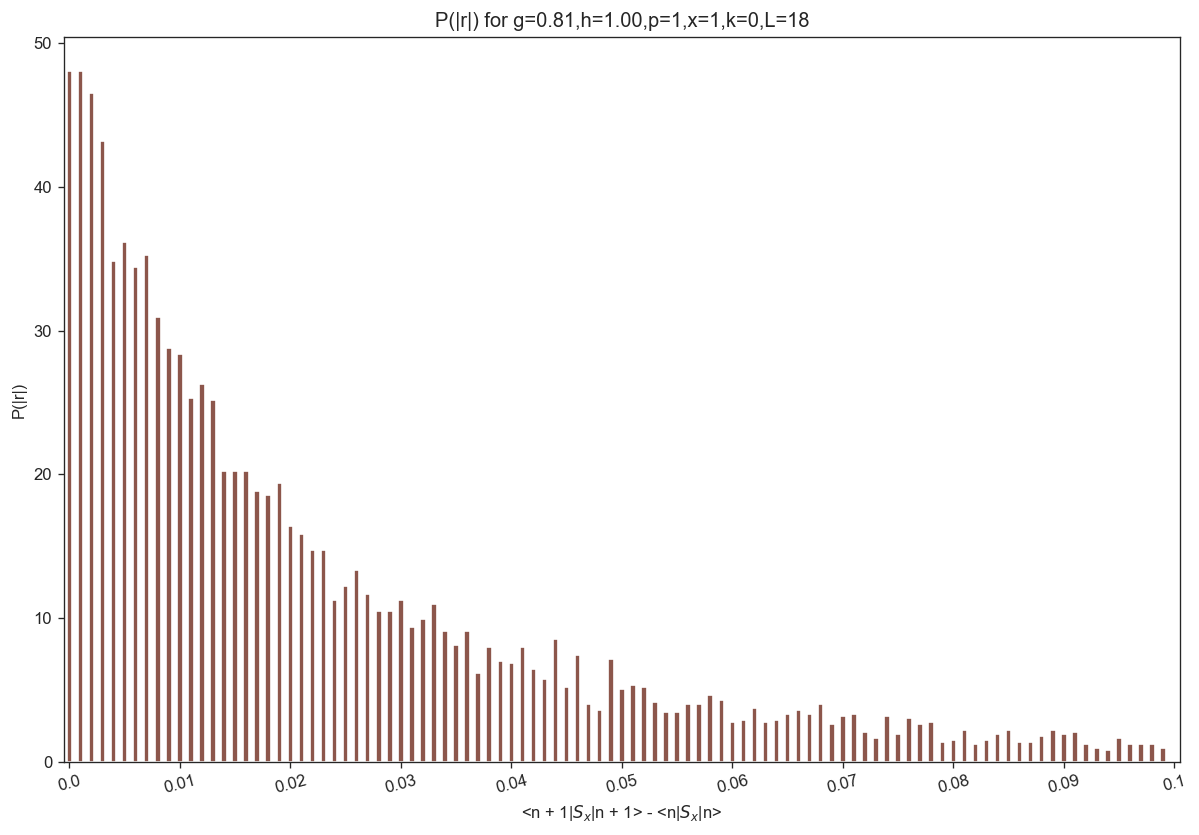

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]


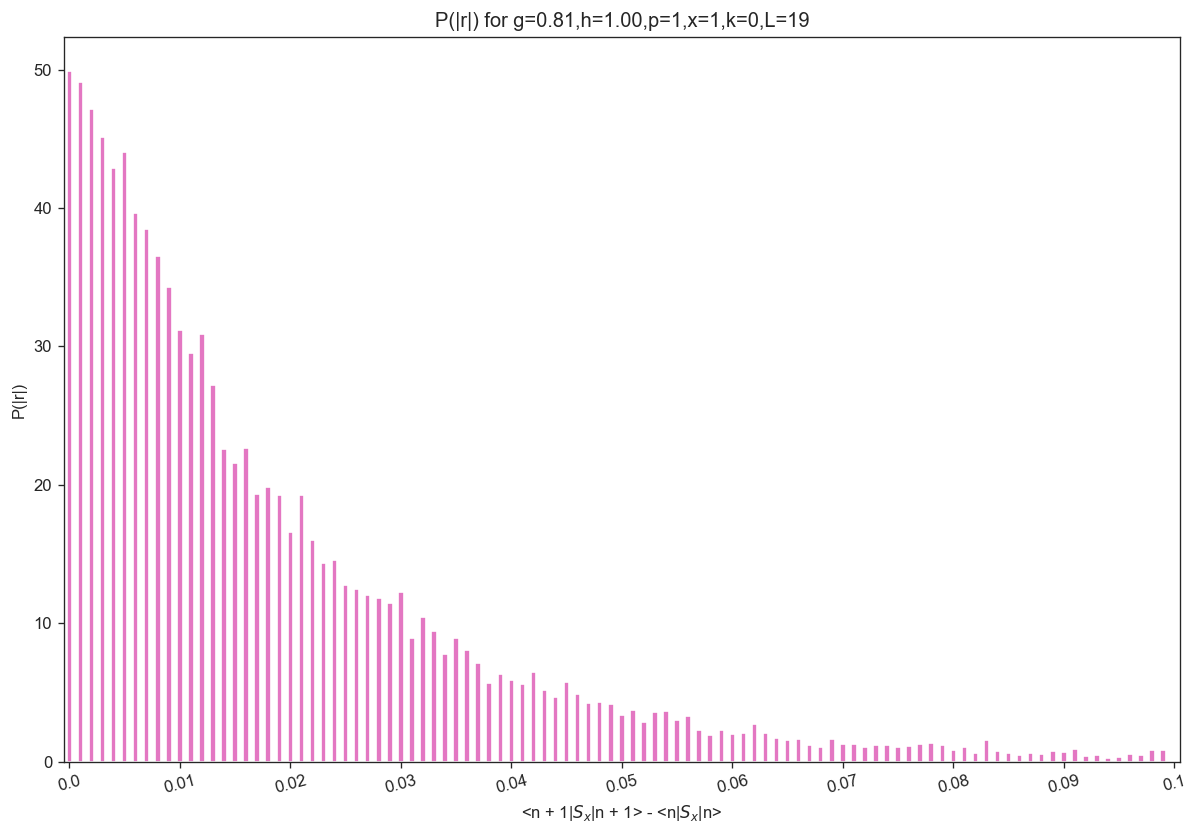

In [166]:
def plot_distribution(directory, file_begin, columns, distinguishers, distribution_name, separator = "\t\t"):
    try:
        folder = 'plots/' + directory 
        if not os.path.isdir(folder):
            os.makedirs(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        # find the list of dataframes
        listOfDf = handle_all_files(directory, file_begin,columns, distinguishers, separator)
        labels = [item[1] for item in listOfDf]
        same_and_diff = findDifferentElementsStrings(labels)
        
        # plot 
        counter = 0
        for df in listOfDf:
            savefile = file_begin + "_" + same_and_diff[0] + "," + labels[counter]
            fig, ax = plt.subplots(len(columns) - 1, figsize=(12,8), dpi = 120) 
            axis = []
            if len(columns) > 2: # if we have many columns to plot
                axis = [ax[i] for i in range(len(columns) - 1)]
            else:
                axis = [ax]
            
            step = 0.01
            _min = np.min(df[0].index)
            _max = np.max(df[0].index)
            new_ticks = [_min + step * i for i in range(0, int((_max-_min)/step) + 1)]
            print(new_ticks)
            itr = 0
            for col in df[0].columns:      

                df[0][col].plot.bar(ax = axis[itr], rot=15, color = next(colors))
                axis[itr].set(title = distribution_name + " for " + same_and_diff[0] + "," + same_and_diff[1][counter]
                            ,xlabel = col
                            ,ylabel = distribution_name)
                #axis[itr].get_legend().remove()
                #(same_and_diff
                #            , frameon=False
                #            , loc='best'
                #            , fontsize=8)
                axis[itr].set_xticks(np.interp(new_ticks, df[0].index, np.arange(df[0].size)))
                axis[itr].set_xticklabels(new_ticks)
                itr+=1
            counter+=1
            plt.savefig(folder + savefile + ".pdf")
            plt.savefig(folder + savefile + ".png")
            plt.show()


plot_distribution(symm_pbc, "ProbDistSpecRapSigmaX", columns = ["P(|r|)", "<n + 1|$S_x$|n + 1> - <n|$S_x$|n>"], distinguishers = [], distribution_name= "P(|r|)", separator = "\t")

[12.0, 0.9, 0.0]


<ipython-input-9-2f188b0074b9>:22: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  tmp = pd.read_csv(folder + filename, sep = "\t\t", names = ['w','bucket','r'])


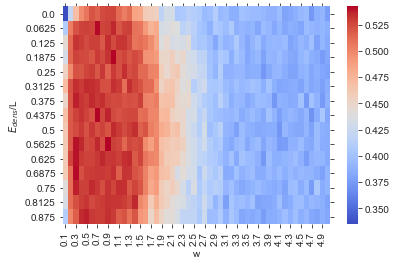

In [9]:
def plot_r_phase(L,g,h, directory):
    try:
        plt.clf()
        plt.cla()
        folder = directory + '/r_phase/'
        if not os.path.isdir(folder):
            os.mkdir(folder)
    except OSError:
        print("Creation of the directory %s failed" % (folder))
    else:
        sns.set_style("ticks")
        #fig, ax = plt.subplots()
        title = "r participation for L=" + str(L) + ", g=" + str(g) + ", h=" +str(h) 
        savefile = "r_L=" + str(L) + ",g=" + str(g) + ",h=" +str(h)
        for filename in os.listdir(folder):
            if (filename.startswith("PhaseDiagram") and (filename[-4:] == '.txt' or filename[-4:] == '.dat')):
                splitter = filename[:-4].split('_')[-1].split(',')
                # L, g, h, w
                splitter = [float(a.split('=')[-1]) for a in splitter]
                if (L == splitter[0] and g == splitter[1] and h == splitter[2]):
                    print(splitter)
                    tmp = pd.read_csv(folder + filename, sep = "\t\t", names = ['w','bucket','r'])
                    tmp.dropna()
                    #print(tmp)
                    tmp = tmp[tmp['r'] != 0.0]

                    #print(tmp)
                    pivotted= tmp.pivot('bucket','w','r')
                    # PLOT 
                    r = np.array(tmp['r'])
                    
                    sns.heatmap(pivotted,cmap='coolwarm',vmin=np.min(r), vmax=np.max(r))
                    
    
    plt.ylabel("$E_{dens}$/L")
    plt.savefig(folder + savefile + ".png")
    plt.show()                


                    
plot_r_phase(12,0.9,0.0,"../results/disorder/") 